# Итерационные методы

## Задания 

1. Реализуйте функцию, вычисляющую $Ax$, где $A$ -\- вышеуказанная дискретизация оператора Лапласса.
Реализуйте функцию, вычисляющую $A^Tx$ на произвольном векторе $x$.

2. Решите дискретизованное уравнение Пуассона выше с помощью функции [`scip.sparse.linalg.spsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.htm). 



## Задание 1

In [1]:
from iter import *
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

In [2]:
n = 3

b = B(n)
print("Ax:")
print(Laplace(n).mul3d(b))

Ax:
[[[-26.25 -11.5  -18.25]
  [-11.5   -0.75  -5.5 ]
  [-18.25  -5.5  -10.25]]

 [[-11.5   -0.75  -5.5 ]
  [ -0.75   6.     3.25]
  [ -5.5    3.25   0.5 ]]

 [[-18.25  -5.5  -10.25]
  [ -5.5    3.25   0.5 ]
  [-10.25   0.5   -2.25]]]


### Задание 2

In [3]:
b = b.reshape((n**3,))

In [4]:
#grid
nx, ny, nz = 3, 3, 3
dx, dy, dz = 1.0, 1.0, 1.0

# boundary conditions
bc_left, bc_right = 0.0, 0.0
bc_top, bc_bottom = 0.0, 0.0
bc_front, bc_back = 0.0, 0.0

n = nx * ny * nz
A = np.zeros((n, n))
b = np.zeros(n)

for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            idx = k + j*nz + i*ny*nz
            if i == 0:
                A[idx, idx] = 1.0
                b[idx] = bc_left
            elif i == nx-1:
                A[idx, idx] = 1.0
                b[idx] = bc_right
            elif j == 0:
                A[idx, idx] = 1.0
                b[idx] = bc_top
            elif j == ny-1:
                A[idx, idx] = 1.0
                b[idx] = bc_bottom
            elif k == 0:
                A[idx, idx] = 1.0
                b[idx] = bc_front
            elif k == nz-1:
                A[idx, idx] = 1.0
                b[idx] = bc_back
            else:
                A[idx, idx] = -2.0 / dx**2 - 2.0 / dy**2 - 2.0 / dz**2
                A[idx, idx-1] = 1.0 / dx**2
                A[idx, idx+1] = 1.0 / dx**2
                A[idx, idx-nz] = 1.0 / dy**2
                A[idx, idx+nz] = 1.0 / dy**2
                A[idx, idx-nz*ny] = 1.0 / dz**2
                A[idx, idx+nz*ny] = 1.0 / dz**2

In [5]:
A_sparse = csc_matrix(A)

u = spsolve(A_sparse, b)

u_grid = np.reshape(u, (nx, ny, nz))

# Задания

3. Какова размерность пространства $K(A,b,m)$, если $A$ - дискретизация лаплассиана, определенная выше?

4. Запишите матрицу $\tilde A_m$ сужения оператора $A$ на пространство Крылова $K(A,b,m)$ в базисе $e_k$:
$$e_0=b,\quad e_1=Ae_0,\quad e_{k+1}=Ae_k.$$
Как раскладывается $Ae_{m-1}$ по векторам $e_0,\ldots,e_{m-1}$?

5. Найдите проекцию $\tilde b$ вектора $b$ на подпространство Крылова $K(A,b,m)$ и решите систему $\tilde A_m \tilde x=\tilde b$
из $m$ уравнений.
Вложите вектор $\tilde x$ обратно в $N^3$ мерное пространство и оцените погрешность решения уравнения $Ax=b$. 
 

# Задание 3

$\dim (K(A, b, m)) \leq m$

# Задание 4

Матрица с нулями везде кроме первой поддиагонали, там единицы

# Задание 5

In [6]:
from scipy.sparse import diags

In [7]:
n = 20

diagonals = [[-2]*n, [1]*(n-1), [1]*(n-1)]

A_diagonal = diags(diagonals, [0, -1, 1])

A = A_diagonal.toarray()

b = np.array([(i/n - 1/2)**2 for i in range(n)])

In [8]:
m_max = 20

krylov_basis = gen_krylov_basis(A, b, m_max)

for m in range(1, m_max):
    cond_number = np.linalg.cond(krylov_basis[:,:m])
    print(f"{m}: {cond_number:2.1e}")

1: 1.0e+00
2: 2.1e+00
3: 9.2e+00
4: 6.1e+01
5: 4.6e+02
6: 3.7e+03
7: 3.0e+04
8: 2.7e+05
9: 2.5e+06
10: 2.8e+07
11: 1.2e+09
12: 8.7e+09
13: 9.6e+10
14: 1.0e+12
15: 1.0e+13
16: 1.1e+14
17: 1.2e+15
18: 1.3e+16
19: 1.6e+17


[источник](https://tbetcke.github.io/hpc_lecture_notes/it_solvers1.html):

"An important measure of the usefulness of a basis is its conditioning. It measures how linearly independent vectors are. A condition number close to `1`
 means that the basis is well behaved. A condition number close to `1e16`
 means that the basis is numerically singular (this is related to the fact that standard double precision has around 16 digits of accuracy)."


Базис ЛЗ

____

 ## Задания

6. Реализуйте метод Ланцоша и найдите ортонормированный базис в пространстве $K(A,b,m)$.
Убедитесь, что матрица $A_m$ оператора $A$ в этом базисе трехдиагональна.

7. Найдите разложение $b_m$ вектора $b$ по построенному базису и решите систему $A_m x_m=b_m$.
Вложите вектор $x_m$ обратно в $N^3$-мерное пространство и найдите ошибку решения. 
Сравните решение с полученным в задании 5.
 

# Задание 6-7


In [9]:
krylov = gen_krylov_basis_orthogonal(A, b, m_max)

for m in range(1, m_max):
    condition_number = np.linalg.cond(krylov[:,:m])
    print(f"{m}: {condition_number:2.1e}")

1: 1.0e+00
2: 1.0e+00
3: 1.0e+00
4: 1.0e+00
5: 1.0e+00
6: 1.0e+00
7: 1.0e+00
8: 1.0e+00
9: 1.0e+00
10: 1.0e+00
11: 1.0e+00
12: 1.0e+00
13: 1.0e+00
14: 1.0e+00
15: 1.0e+00
16: 1.0e+00
17: 1.0e+00
18: 1.0e+00
19: 1.0e+00


In [10]:
x, V, error = FOM(A, b, m_max=20)

Text(0.5, 1.0, 'Ошибка от m')

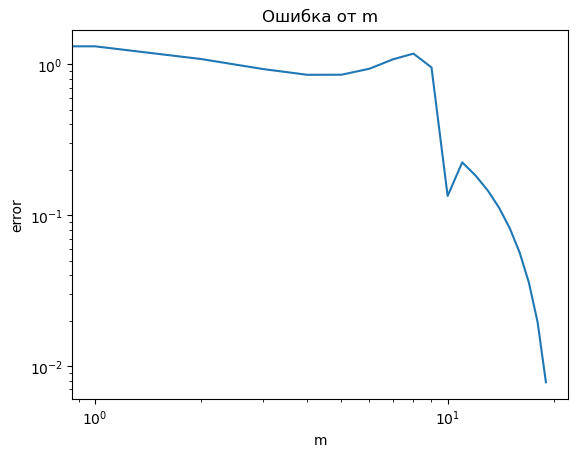

In [11]:
plt.loglog(error)
plt.xlabel('m')
plt.ylabel("error")
plt.title('Ошибка от m')

## Задания

8. Используйте $K=K(A,b,m)$, $L=A K$ и решите уравнение Пуассона метода Петрова-Галеркина. 
Оцените ошибку получившегося решения.
Получающийся метод имеет название [GMRES](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method).
Убедитесь, что этот подход минимизирует невязку по всем $x\in K$.

9. Оцените время работы алгоритма как функцию от $m$.

# Задание 8

In [12]:
from scipy.sparse.linalg import gmres

In [13]:
A = np.array([[8, 0, 0],
              [0, 2, 0],
              [0, 0, 3]])

b = np.array([1, 3, 7])

x0 = np.zeros(b.shape)

print("LAB GMRES: ", GMRES_LAB(A, b, np.zeros_like(b), 100))

print("Scipy's GMRES: ", gmres(A, b, np.zeros_like(b), 1e-8))

LAB GMRES:  (array([0.125     , 1.5       , 2.33333333]), 4.181294568627079e-15)
Scipy's GMRES:  (array([0.125     , 1.5       , 2.33333333]), 0)


----


## Ускорение Лапласа

In [14]:
n = 10

A = Numbaplace(n)
A.shape = (n**3, n**3)
b = B(n).flatten()

m_max = 10

krylov_basis = gen_krylov_basis(A, b, m_max)

In [15]:
%%timeit
gen_krylov_basis(A, b, m_max)

303 µs ± 4.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Если сравнить с обычным


In [16]:
A = Laplace(n)
A.shape = (n**3, n**3)
b = B(n).flatten()

m_max = 10

krylov_basis = gen_krylov_basis(A, b, m_max)

In [17]:
%%timeit
gen_krylov_basis(A, b, m_max)

65.6 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Через нумбу работает порядка $10^{-4}$ секунд, а без нумбы порядка $10^{-2}$ секунд!

-----

## Проверка правильности

In [18]:
n = 100

def sin3D(x, y, z):
    return np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y) * np.sin(2 * np.pi * z)

In [19]:
ax_arr = np.linspace(0, 1, n)

grid = np.empty((n, n, n))

In [20]:
for i in range(n):
    for j in range(n):
        for k in range(n):
            grid[i, j, k] = sin3D(ax_arr[i], ax_arr[j], ax_arr[k])

In [21]:
A_nb = Numbaplace(n)

result_nb = A_nb.mul(grid, n)

In [22]:
A_old = Laplace(n)
result_old = A_old.mul3d(grid)

In [23]:
print((result_nb / grid)[:,47, 10])

[            inf -1.20801541e+02 -1.20804001e+02 -1.20794583e+02
 -1.20800380e+02 -1.20799303e+02 -1.20796057e+02 -1.20796377e+02
 -1.20795812e+02 -1.20799055e+02 -1.20798225e+02 -1.20799966e+02
 -1.20796347e+02 -1.20799409e+02 -1.20794991e+02 -1.20797411e+02
 -1.20799467e+02 -1.20800700e+02 -1.20798825e+02 -1.20796775e+02
 -1.20805097e+02 -1.20798856e+02 -1.20794609e+02 -1.20798488e+02
 -1.20799367e+02 -1.20802406e+02 -1.20796973e+02 -1.20802545e+02
 -1.20796235e+02 -1.20800407e+02 -1.20801656e+02 -1.20797826e+02
 -1.20796871e+02 -1.20797823e+02 -1.20797738e+02 -1.20800682e+02
 -1.20803427e+02 -1.20800417e+02 -1.20797853e+02 -1.20803151e+02
 -1.20797425e+02 -1.20796755e+02 -1.20799736e+02 -1.20798876e+02
 -1.20796448e+02 -1.20797775e+02 -1.20800956e+02 -1.20799093e+02
 -1.20805592e+02 -1.20797619e+02 -1.20797619e+02 -1.20805592e+02
 -1.20799093e+02 -1.20800956e+02 -1.20797775e+02 -1.20796448e+02
 -1.20798876e+02 -1.20799736e+02 -1.20796755e+02 -1.20797425e+02
 -1.20803151e+02 -1.20797

C:\Users\roman\AppData\Local\Temp\ipykernel_2700\3495151761.py:1: RuntimeWarning: divide by zero encountered in divide
  print((result_nb / grid)[:,47, 10])
C:\Users\roman\AppData\Local\Temp\ipykernel_2700\3495151761.py:1: RuntimeWarning: invalid value encountered in divide
  print((result_nb / grid)[:,47, 10])


$\Delta \sin(2 \pi x) = \lambda \sin(2 \pi x)$, найдём $\lambda$

$\Delta \sin(2 \pi x) = \dfrac{\sin(2\pi (x + h)) - 2\sin(2\pi x) + \sin(2 \pi (x - h))}{h^2}$ =

$= \dfrac{\sin(2\pi x) \cos(2\pi h) + \sin(2\pi h)\cos(2\pi x) - 2 \sin(2\pi x) + \sin(2\pi x)\cos(2\pi h) - \sin(2\pi h) \cos(2\pi x)}{h^2} =$

$= \dfrac{2\sin(2\pi x)\cos(2\pi h) - 2\sin(2\pi x)}{h^2} = \dfrac{2}{h^2}\left( \cos(2\pi h) - 1 \right) \sin(2\pi x) \rightarrow - 4\pi^2 \sin(2\pi x)$ при $h \rightarrow 0$ 

Аналогично по двум другим осям, если шаг одинаковый, то множитель будет $\dfrac{6}{h^2}\left( \cos(2\pi h) - 1 \right)$

In [24]:
h = 1 / n
print(6 * (np.cos(2*np.pi * h) - 1) / h**2)

-118.39629430370645


А получилось на самом деле:

In [25]:
print((result_nb / grid)[1,47, 10])

-120.80154149070884


C:\Users\roman\AppData\Local\Temp\ipykernel_2700\4262605877.py:1: RuntimeWarning: divide by zero encountered in divide
  print((result_nb / grid)[1,47, 10])
C:\Users\roman\AppData\Local\Temp\ipykernel_2700\4262605877.py:1: RuntimeWarning: invalid value encountered in divide
  print((result_nb / grid)[1,47, 10])
